CHAPTER 08 이미지를 위한 인공 신경망  
8-3 합성곱 신경망의 시각화

In [1]:
# 체크포인트 파일 읽어오기
import keras
model = keras.models.load_model('best-cnn-model.keras')

2025-11-23 21:51:12.515057: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-23 21:51:12.515837: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-23 21:51:12.519621: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-23 21:51:12.532640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763902272.553554   27110 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763902272.55

In [2]:
# 케라스 모델에 추가한 층 출력
model.layers

[<Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense_1, built=True>]

In [ ]:
# 첫 번째 합성곱 층의 가중치 확인(가중치,절편 크기)
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 1, 32) (32,)


In [ ]:
conv_weights = conv.weights[0].numpy() # 넘파이 배열로 변환
print(conv_weights.mean(), conv_weights.std()) # 가중치 배열의 평균, 표준편차 계산

-0.025099454 0.25427943


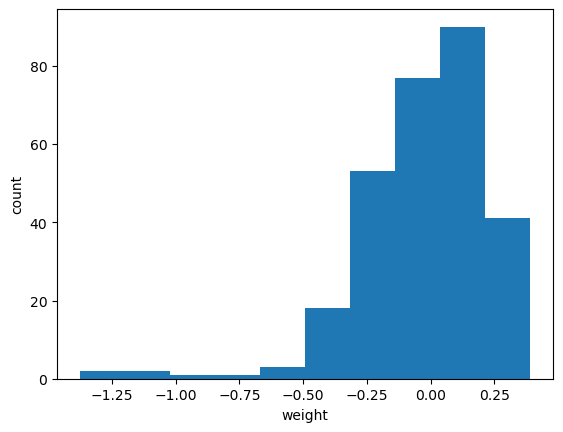

In [ ]:
# 가중치 분포 히스토그램
import matplotlib.pyplot as plt

plt.hist(conv_weights.reshape(-1,1)) # hist() 함수에 1차원 배열로 전달위해 변환
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

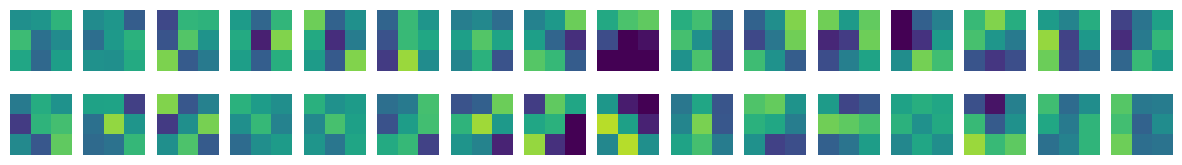

In [ ]:
# 32개 커널 16개씩 두 줄로 출력
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
    for j in range(16):
        axs[i, j].imshow(conv_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5) # 배열의 최댓값과 최솟값으로 픽셀의 강도 표현(최댓값 밝은 노랑, vmin과 vmax로 범위 지정)
        axs[i, j].axis('off')
plt.show()

In [ ]:
# 훈련하지 않은 빈 합성곱 신경망 만들기
no_training_model = keras.Sequential()
no_training_model.add(keras.layers.Input(shape=(28,28,1)))
no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation=\
                                          'relu', padding='same'))

# 모델의 첫번째 합성곱층의 가중치를 no_training_conv 변수에 저장
no_training_conv = no_training_model.layers[0]
print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [11]:
# 가중치의 평균과 표준편차 확인
no_training_weights = no_training_conv.weights[0].numpy()
print(no_training_weights.mean(),no_training_weights.std())

0.004807459 0.08400471


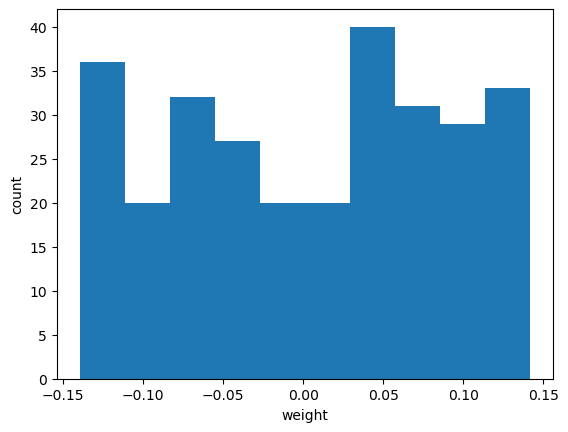

In [12]:
# 가중치 분포 히스토그램
plt.hist(no_training_weights.reshape(-1,1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

[가중치가 고른 분포를 보이는 이유]  
케라스가 신경망의 가중치를 처음 초기화할 때 균등 분포에서 랜덤하게 값을 선택하기 때문

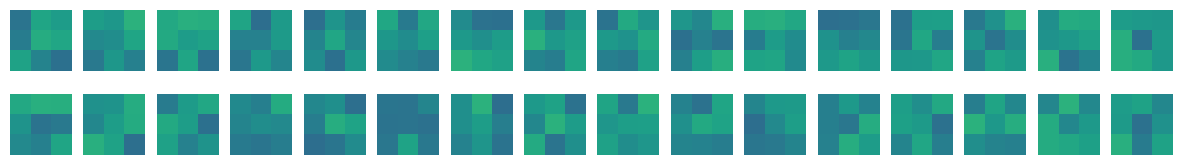

In [15]:
# 맷플롯립의 imshow() 함수를 이용해 가중치 값을 그림으로 출력
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
    for j in range(16):
        axs[i, j].imshow(no_training_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')
plt.show()

[함수형 API]   
- 각 레이어를 함수처럼 호출해서 연결  
- 입력과 출력을 명시적으로 정의  
- 복잡한 모델(예: 분기, 병렬, 다중 입력/출력)도 가능

In [18]:
inputs = keras.Input(shape=(784,))
dense1 = keras.layers.Dense(100, activation='relu')
dense2 = keras.layers.Dense(10, activation='softmax')

hidden = dense1(inputs) 
outputs = dense2(hidden)
func_model = keras.Model(inputs, outputs)

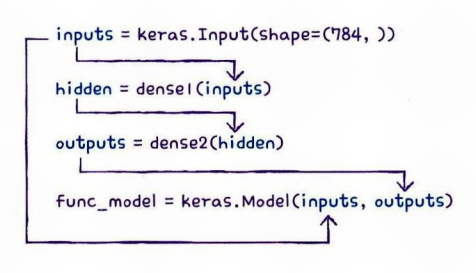

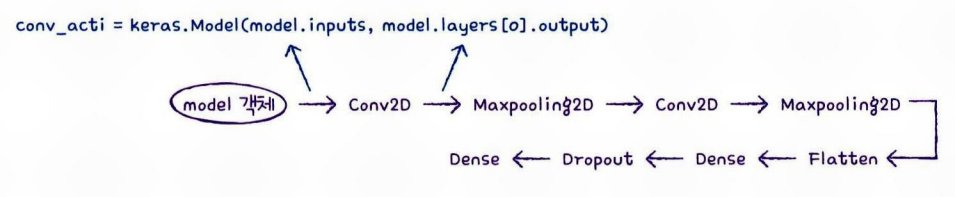

In [ ]:
# 모델 입력
print(model.inputs)

[<KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=False, name=input_layer>]


In [ ]:
# model.inputs의 첫 번째 원소와 model.layer[0].output을 연결하는 새로운 conv_acit 모델 만듦
conv_acti = keras.Model(model.inputs[0], model.layers[0].output)

model 객체의 predict() 메서드를 호출하면 최종 출력층의 확률을 반환  
하지만, conv_acit의 predict() 메서드를 호출하면 첫 번째 Conv2D의 출력을 반환함  

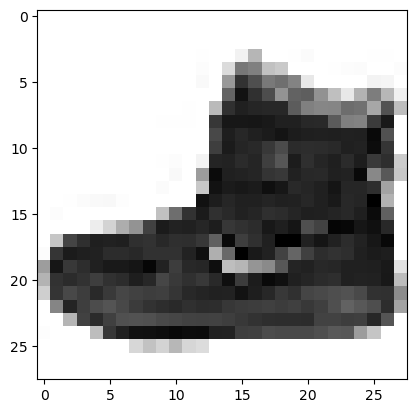

In [22]:
# 특성 맵 시각화
(train_input, train_target), (test_input, test_target) =\
keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

In [25]:
# 위 샘플을 conv_acti 모델에 주입
ankle_boot = train_input[0:1].reshape(-1, 28, 28, 1)/255.0
feature_maps = conv_acti.predict(ankle_boot)

# 크기 확인
print(feature_maps.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
(1, 28, 28, 32)


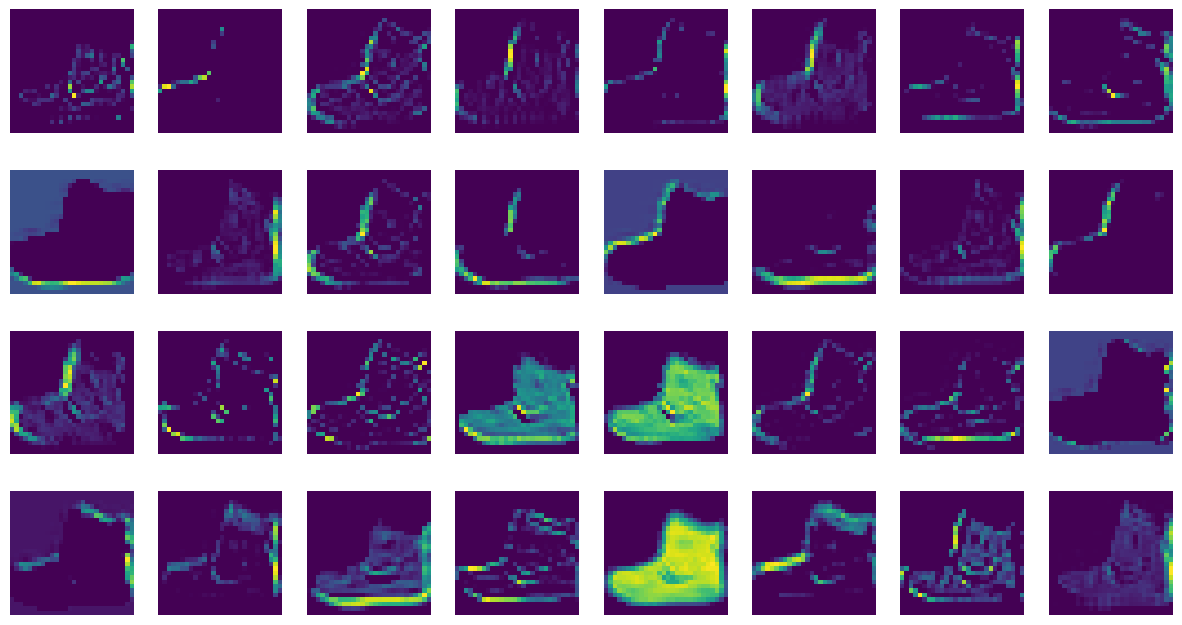

In [26]:
fig, axs = plt.subplots(4, 8, figsize =(15,8))
for i in range(4):
    for j in range(8):
        axs[i,j].imshow(feature_maps[0,:,:,i*8 +j])
        axs[i,j].axis('off')
plt.show()

In [28]:
# model 객체의 입력과 두 번째 합성곱 층의 출력을 연결한 모델 만들기
conv2_acti = keras.Model(model.inputs[0],model.layers[2].output)

# 앵클 부츠 샘플을 위 모델의 predict() 메서드에 전달
feature_maps = conv2_acti.predict(ankle_boot)

# 크기 확인
print(feature_maps.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
(1, 14, 14, 64)


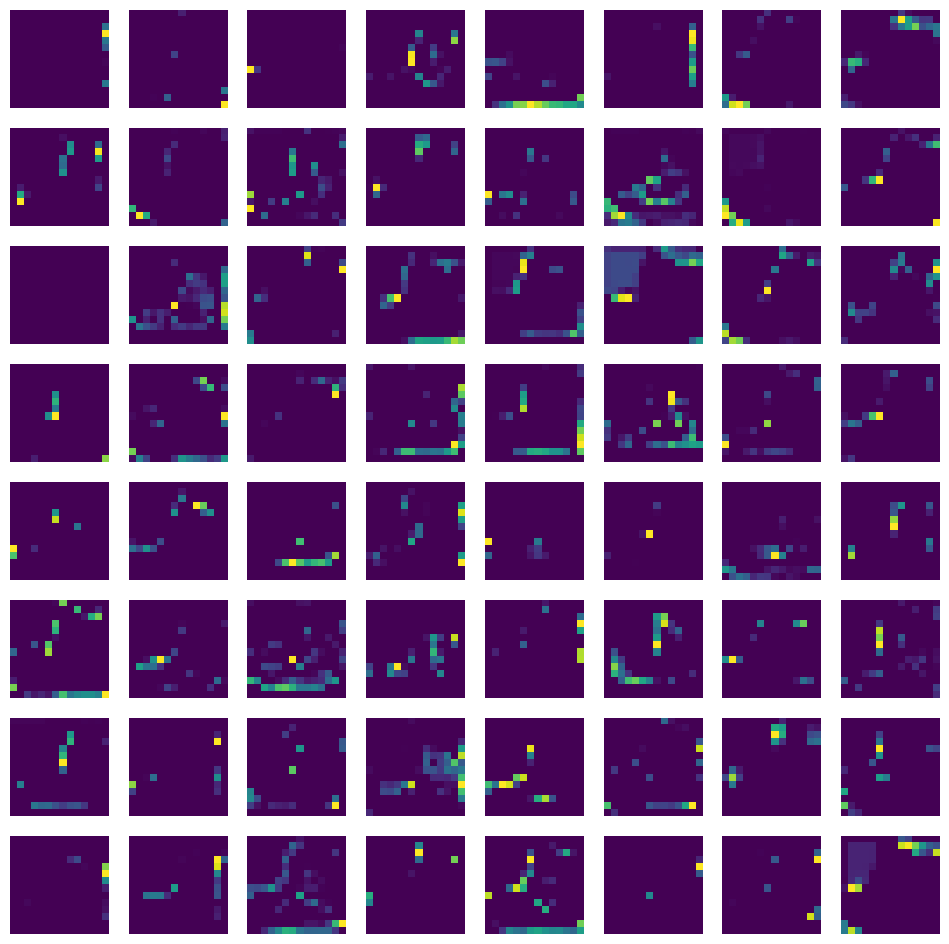

In [31]:
fig, axs = plt.subplots(8,8,figsize=(12,12))
for i in range(8):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8+j])
        axs[i,j].axis('off')
plt.show()

> 입력에 가까운 합성곱 층은 경계, 색깔 같은 저수준의 특징을 감지하고  
출럭에 가까운 합성곱 층은 추성적인 특징을 감지함